In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)


In [2]:
Undersampling = "Regular" #Regular or Possoin
Sampling_Mask = "Complementary_Masks" #One_Mask or Single_Combination or Complementary_Masks
AF = 3

In [3]:
import numpy as np

def low_rank_compression_last_axis(tensor: np.ndarray, rank: int) -> np.ndarray:
    """
    Compresses the last dimension of a 5D tensor using low-rank approximation via SVD.
    
    This function reshapes the tensor to 2D by merging the first four dimensions, 
    performs an SVD on the reshaped tensor, truncates the SVD to the specified rank, 
    and then reconstructs the tensor with the last axis reduced to 'rank'.
    
    Parameters:
        tensor (np.ndarray): Input 5D tensor of shape (d1, d2, d3, d4, d5)
        rank (int): Desired low-rank approximation (must be <= d5)
    
    Returns:
        tuple: (Compressed 5D tensor of shape (d1, d2, d3, d4, rank), Vh)
               Vh contains the right singular vectors from the SVD.
    """
    # Get original shape
    d1, d2, d3, d4, d5 = tensor.shape
    if rank > d5:
        raise ValueError(f"Rank must be ≤ {d5}, but got {rank}.")

    # If the tensor has complex values, ensure it is a complex type
    if not np.iscomplexobj(tensor) and np.any(np.iscomplex(tensor)):
        tensor = tensor.astype(np.complex128)
    
    # Reshape the tensor to 2D by merging the first four dimensions.
    # New shape: (d1*d2*d3*d4, d5)
    tensor_reshaped = tensor.reshape(-1, d5)
    
    # Perform SVD on the reshaped tensor.
    U, S, Vh = np.linalg.svd(tensor_reshaped, full_matrices=False)
    
    # Truncate to the specified rank.
    U_reduced = U[:, :rank]             # Shape: (d1*d2*d3*d4, rank)
    S_reduced = np.diag(S[:rank])         # Shape: (rank, rank)
    
    # Compute the compressed representation.
    compressed_2D = U_reduced @ S_reduced  # Shape: (d1*d2*d3*d4, rank)
    
    # Reshape back to a 5D tensor.
    # New shape becomes: (d1, d2, d3, d4, rank)
    result = compressed_2D.reshape(d1, d2, d3, d4, rank)
    
    return result, Vh


def reconstruct_from_low_rank_last_axis(compressed_tensor: np.ndarray, Vh: np.ndarray, rank) -> np.ndarray:
    """
    Reconstructs the approximated original tensor from the compressed representation obtained via low-rank SVD.
    
    Parameters:
        compressed_tensor (np.ndarray): Compressed 5D tensor of shape (d1, d2, d3, d4, rank),
                                        representing U_reduced @ S_reduced.
        Vh (np.ndarray): The right singular vectors from the SVD on the reshaped tensor.
                         Typically of shape (d5, d5) but only the top `rank` rows (i.e. Vh[:rank, :])
                         are needed for reconstruction.
    
    Returns:
        np.ndarray: Reconstructed 5D tensor of shape (d1, d2, d3, d4, d5), which is the
                    rank-truncated approximation of the original tensor.
    """
    # Get the shape of the compressed tensor.
    d1, d2, d3, d4, rank = compressed_tensor.shape
    
    # Reshape the compressed tensor back to 2D.
    # It currently has shape (d1, d2, d3, d4, rank); reshape to (d1*d2*d3*d4, rank)
    compressed_2D = compressed_tensor.reshape(-1, rank)
    
    # Truncate Vh: use only the first 'rank' rows.
    Vh_reduced = Vh[:rank, :]  # shape: (rank, d5)
    
    # Multiply to reconstruct the 2D tensor.
    # Resulting shape will be (d1*d2*d3*d4, d5)
    reconstructed_2D = compressed_2D @ Vh_reduced
    
    # Reshape the 2D reconstruction back to 5D.
    d5 = Vh_reduced.shape[1]
    reconstructed_tensor = reconstructed_2D.reshape(d1, d2, d3, d4, d5)
    
    return reconstructed_tensor



In [4]:
Patient = 0
rank = 8

Ground_Truth = np.load('../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')[..., Patient]

Undersampled_Data = np.load("../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy')[...,Patient]

Ground_Truth = np.swapaxes(Ground_Truth, -1, -2)
Undersampled_Data = np.swapaxes(Undersampled_Data, -1, -2) ## now t is last

US_Compressed, Vh_U = low_rank_compression_last_axis(Undersampled_Data, rank)
GT_Compressed, Vh = low_rank_compression_last_axis(Ground_Truth, rank)

US_Uncompressed = reconstruct_from_low_rank_last_axis(GT_Compressed, Vh_U, rank)
GT_Unompressed = reconstruct_from_low_rank_last_axis(GT_Compressed, Vh, rank)

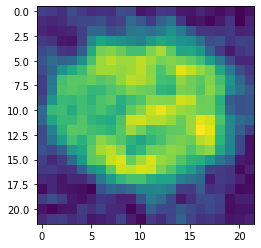

In [17]:
t, T, z = 1,0,11

SLICE = np.abs(US_Uncompressed)[:,:,z,T,t]
plt.imshow(SLICE)

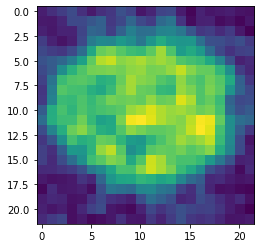

In [18]:
t, T, z = 1,0,11

SLICE = np.abs(GT_Unompressed)[:,:,z,T,t]
plt.imshow(SLICE)

In [7]:
# rank = 8
# Patient = 4

# Ground_Truth = np.load('../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')

# Undersampled_Data = np.load("../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy')[...,Patient]
# US_Compressed = low_rank_compression_swapped(Undersampled_Data, rank)


# #### Generate noise
# noise = np.concatenate([Ground_Truth[:,:,:,66:,:,1], Ground_Truth[:,:,:,66:,:,2], Ground_Truth[:,:,:,66:,:,3], Ground_Truth[:,:,:,90:,:,4]], axis=3)  
# axis_to_shuffle = 3
# shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
# noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)

# Ground_Truth = Ground_Truth[..., Patient]
# GT_Compressed = low_rank_compression_swapped(Ground_Truth, rank)


# Ground_Truth_L8 = low_rank(Ground_Truth, rank)
# #####

# Ground_Truth2 = Ground_Truth_L8 + noise
# GT_Compressed = low_rank_compression_swapped(Ground_Truth, rank)

# GT_Compressed  = np.fft.fftshift(np.fft.fft(GT_Compressed, axis=-2), axes=-2)

# GT2_Compressed = low_rank_compression_swapped(Ground_Truth2, rank)
# GT2_Compressed  = np.fft.fftshift(np.fft.fft(GT2_Compressed, axis=-2), axes=-2)
# US_Compressed= np.fft.fftshift(np.fft.fft(US_Compressed, axis=-2), axes=-2)

# xlabel = 'X-axis'
# ylabel = 'Y-axis'
# title = '1D Line Plot'

# plt.figure(figsize=(8, 5))
# plt.plot(np.abs(GT_Compressed[10,10,10,:,0]), marker='o', linestyle='-', color='b', label='GT1')
# plt.plot(np.abs(US_Compressed[10,10,10,:,0]), marker='o', linestyle='-', color='r', label='US')
# plt.plot(np.abs(GT2_Compressed[10,10,10,:,0]), marker='o', linestyle='-', color='y', label='GT2')
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.title(title)
# plt.legend()
# plt.grid(True)
# plt.show()


NameError: name 'low_rank_compression_swapped' is not defined

In [29]:
Patient = 5

Rank = 8

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,Patient]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

### Load data and tracuate
Ground_Truth = np.load('../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')  #combined_trancuated_k_space_low_rank_15

#### Generate noise
noise = np.concatenate([Ground_Truth[:,:,:,66:,:,1], Ground_Truth[:,:,:,66:,:,2], Ground_Truth[:,:,:,66:,:,3], Ground_Truth[:,:,:,90:,:,4]], axis=3)  
axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)

#####
Ground_Truth = Ground_Truth[...,Patient]

Ground_Truth = np.swapaxes(Ground_Truth, -1, -2)
GT_Compressed, Vh = low_rank_compression_last_axis(Ground_Truth, Rank)
Ground_Truth_L8 = reconstruct_from_low_rank_last_axis(GT_Compressed, Vh, Rank)
Ground_Truth_L8 = np.swapaxes(Ground_Truth_L8, -1, -2)

Ground_Truth2 = Ground_Truth_L8 + noise
Ground_Truth2_L8 = low_rank(Ground_Truth2, Rank)*mask_5D
Ground_Truth_L8 = Ground_Truth_L8*mask_5D

#Undersampled_Data = np.swapaxes(Undersampled_Data, -1, -2) ## now t is last
Undersampled_Data = np.load("../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy')[...,Patient]
Undersampled_Data = np.swapaxes(Undersampled_Data, -1, -2)

US_Compressed, Vh_U = low_rank_compression_last_axis(Undersampled_Data, rank)
Undersampled_Data_L8 = reconstruct_from_low_rank_last_axis(GT_Compressed, Vh_U, rank)*mask_5D # PERFEKT Reconstruction
Undersampled_Data_L8 = np.swapaxes(Undersampled_Data_L8, -1, -2)

### Load undersampled data and trancuate
# Undersampled_Data = np.load("../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy')[...,Patient]
# Undersampled_Data_L8 = low_rank(Undersampled_Data, Rank)*mask_5D
#### extract noise, add it to ground truth to create noise equivalent ground truth

# Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth2, axis=-2),axes=-2)
# Ground_Truth_2_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth2_L8, axis=-2),axes=-2)
# Ground_Truth_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-2),axes=-2)
# Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-2),axes=-2)

# Undersampled_Data_Spectral = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-2),axes=-2)
# Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-2),axes=-2)

_, _, norm_values_test = normalize_data_per_image_new(Ground_Truth_L8, Ground_Truth2_L8)

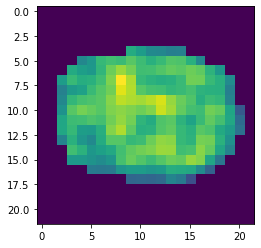

In [26]:
t, T, z = 1,0,10

SLICE = np.abs(Undersampled_Data_L8)[:,:,z,t,T]
plt.imshow(SLICE)

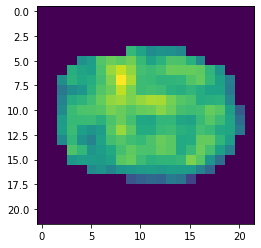

In [27]:
t, T, z = 1,0,10

SLICE = np.abs(Ground_Truth_L8)[:,:,z,t,T]
plt.imshow(SLICE)

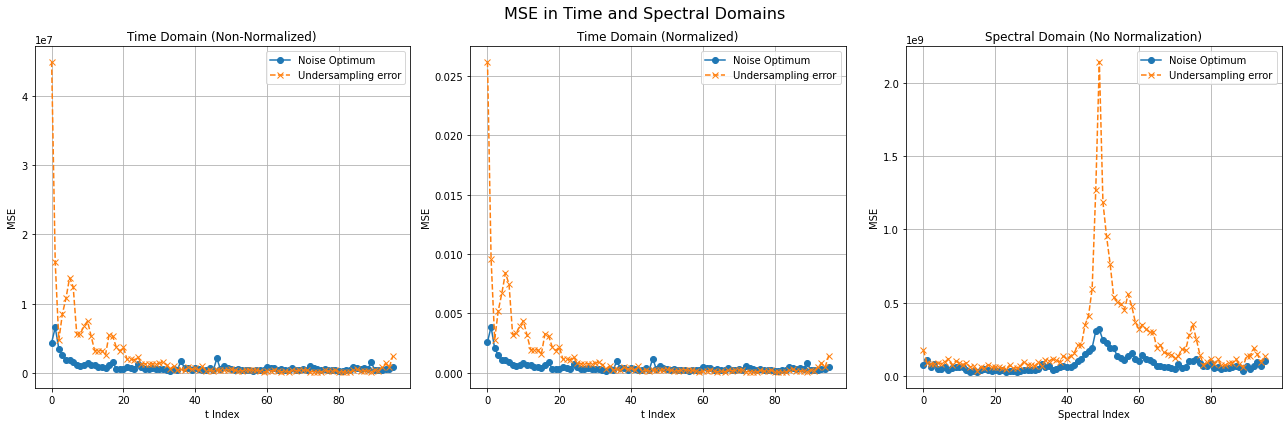

==== Model Output vs Ground Truth ====
Total MSE in image domain: 420614.7516900699
Normalized Total MSE in image domain: 0.0002468709253075615
Total MSE in spectral domain: 40379016.162246704

==== Model Input vs Ground Truth ====
Total MSE in image domain: 1144391.1171040873
Normalized Total MSE in image domain: 0.0006809456549751597
Total MSE in spectral domain: 109861547.24199237


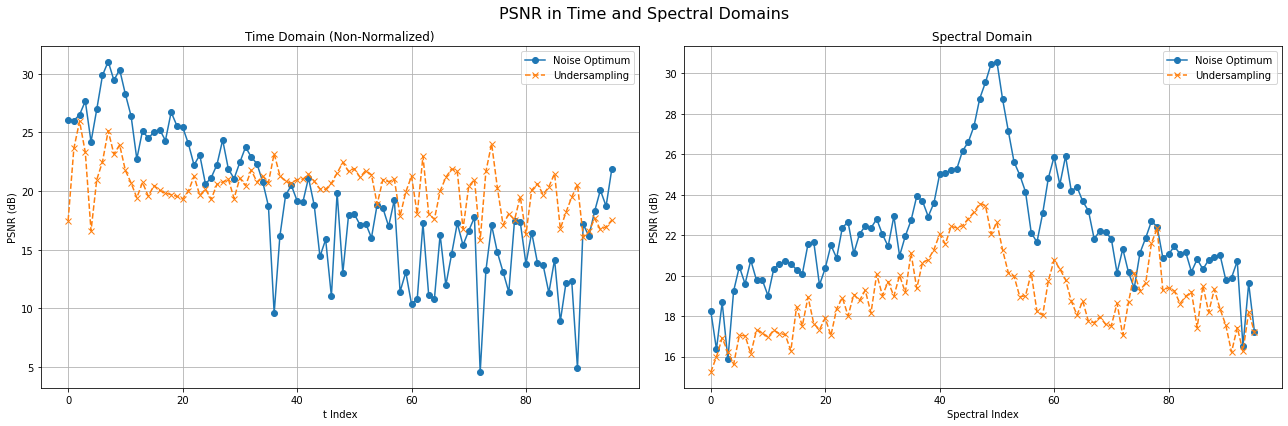

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    18.786411156850576
Average PSNR in frequency domain: 22.214491718195063

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    20.24086778951293
Average PSNR in frequency domain: 18.975728618204542


In [ ]:
label = "Noise Optimum"

_, _, norm_values_test = normalize_data_per_image_new(Ground_Truth_L8, Ground_Truth2_L8)

plot_general_statistics(Ground_Truth2_L8, Undersampled_Data_L8, Ground_Truth_L8, 96, norm_values_test, label, label2="Undersampling error")
plot_general_statistics_PSNR(Ground_Truth2_L8, Undersampled_Data_L8, Ground_Truth_L8, 96, norm_values_test, label, label2="Undersampling")
plot_general_statistics_SSIM(Ground_Truth2_L8, Undersampled_Data_L8, Ground_Truth_L8, 96, norm_values_test, label, label2="Undersampling")

Optimal statistics

In [ ]:
label = "GT + noise"

tf = 50 # 50 = water, 60 = Glc, 78 = Glx
T = 7

Ground_Truth2_L8_swapped = np.swapaxes(Ground_Truth2_L8, 0, 2)
Ground_Truth_L8_swapped = np.swapaxes(Ground_Truth_L8, 0, 2)
Undersampled_Data_L8_swapped = np.swapaxes(Undersampled_Data_L8, 0, 2)

comparison_Plot_3D_vs_Ifft(Ground_Truth2_L8_swapped, Ground_Truth_L8_swapped, Undersampled_Data_L8_swapped, tf, T, domain="spectral", label = label, label2 = "undersampled + LR8")

In [ ]:
label = "GT + noise"

t = 1 # 50 = water, 60 = Glc, 78 = Glx
T = 7

Ground_Truth2_L8_swapped = np.swapaxes(Ground_Truth2_L8, 0, 2)
Ground_Truth_L8_swapped = np.swapaxes(Ground_Truth_L8, 0, 2)
Undersampled_Data_L8_swapped = np.swapaxes(Undersampled_Data_L8, 0, 2)

comparison_Plot_3D_vs_Ifft(Ground_Truth2_L8_swapped, Ground_Truth_L8_swapped, Undersampled_Data_L8_swapped, t, T, domain="time", label = label, label2 = "undersampled + LR8")

In [ ]:
Patient = 0
x, y, T = 10, 15, 7

indices = range(6, 15) 
num_rows = len(indices)
num_cols = 2  # left column: arr1 vs arr2; right column: arr3 vs arr4
# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), sharex=True)

# If there's only one row, axs may not be 2D, so ensure we have a 2D array:
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare arr1 and arr2
    ax_left = axs[i, 0]
    ax_left.plot(np.abs(Ground_Truth_Spectral[x, y, idx, :, T]), label="Fully Sampled", color='red')
    ax_left.plot(np.abs(Ground_Truth_2_Spectral[x, y, idx, :, T]), label="Fully Sampled 2", color='green', linestyle='--')
    ax_left.plot(np.abs(Undersampled_Data_Spectral[x, y, idx, :, T]), label=f"Undersampled Regular", color='blue', linestyle='--')
    ax_left.set_title(f" z = {idx}")
    ax_left.legend()
    ax_left.legend(loc="upper left")
    
    # Right subplot: compare arr3 and arr4
    ax_right = axs[i, 1]
    ax_right.plot(np.abs(Ground_Truth_Spectral_L8[x, y, idx, :, T]), label="Fully Sampled + LR 8", color='red')
    ax_right.plot(np.abs(Ground_Truth_2_Spectral_L8[x, y, idx, :, T]), label="Fully Sampled 2 + LR 8", color='green', linestyle='--')
    ax_right.plot(np.abs(Undersampled_Data_Spectral_L8[x, y, idx, :, T]), label="Undersampled + LR 8", color='blue', linestyle='--')
    ax_right.set_title(f" z = {idx}")
    ax_right.legend()
    ax_right.legend(loc="upper left")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x, y, T = 10, 15, 7

indices = range(0, 20) 
num_rows = len(indices)
num_cols = 2  # First column for spectra, second for residuals

# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3.5), sharex=True)

# Ensure axs is always a 2D array
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare original spectra
    ax_left = axs[i, 0]  # First column
    spectrum_fs1 = np.abs(Ground_Truth_Spectral_L8[x, y, idx, :, T])
    spectrum_fs2 = np.abs(Ground_Truth_2_Spectral_L8[x, y, idx, :, T])
    spectrum_us = np.abs(Undersampled_Data_Spectral_L8[x, y, idx, :, T])

    ax_left.plot(spectrum_fs1, label="Fully Sampled + LR 8", color='red')
    ax_left.plot(spectrum_fs2, label="Fully Sampled 2 + LR 8", color='green', linestyle='--')
    ax_left.plot(spectrum_us, label="Undersampled + LR 8", color='blue', linestyle='--')
    ax_left.set_title(f"Spectra at z = {idx}")
    ax_left.legend(loc="upper left")
    ax_left.set_ylim(-50000, 400000)  # Fixed y-axis range

    # Right subplot: residuals
    ax_right = axs[i, 1]  # Second column
    residual_fs1_fs2 = spectrum_fs1 - spectrum_fs2
    residual_fs1_us = spectrum_fs1 - spectrum_us

    ax_right.plot(residual_fs1_fs2, label="Fully sampled 1 - Fully sampled 2", color='green', linestyle='--')
    ax_right.plot(residual_fs1_us, label="Fully sampled 1 - Undersampled", color='blue', linestyle='--')
    ax_right.set_title(f"Residuals at z = {idx}")
    ax_right.legend(loc="upper left")
    ax_right.set_ylim(-50000, 400000)  # Fixed y-axis range

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
extra = 400

Ground_Truth2_L8_interpolated = np.zeros((22,22,21,extra,8))*1J
Ground_Truth2_L8_interpolated[:,:,:,:96,:] = Ground_Truth2_L8

Ground_Truth_L8_interpolated = np.zeros((22,22,21,extra,8))*1J
Ground_Truth_L8_interpolated[:,:,:,:96,:] = Ground_Truth_L8

Undersampled_Data_L8_interpolated = np.zeros((22,22,21,extra,8))*1J
Undersampled_Data_L8_interpolated[:,:,:,:96,:] = Undersampled_Data_L8

Ground_Truth_2_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth2_L8_interpolated, axis=-2),axes=-2)
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8_interpolated, axis=-2),axes=-2)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8_interpolated, axis=-2),axes=-2)


In [ ]:
Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth2, axis=-2),axes=-2)
Ground_Truth_2_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth2_L8, axis=-2),axes=-2)
Ground_Truth_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-2),axes=-2)
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-2),axes=-2)

Undersampled_Data_Spectral = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-2),axes=-2)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-2),axes=-2)

# ***Investigate different time steps - T***
Here I check if there is something to learn at AF = 3 for later timesteps T

In [ ]:
Patient = 5

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,Patient]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

### Load data and tracuate
Ground_Truth = np.load('../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')  #combined_trancuated_k_space_low_rank_15

#### Generate noise
noise = np.concatenate([Ground_Truth[:,:,:,66:,:,1], Ground_Truth[:,:,:,66:,:,2], Ground_Truth[:,:,:,66:,:,3], Ground_Truth[:,:,:,90:,:,4]], axis=3)  
axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)

#####
Ground_Truth = Ground_Truth[...,Patient]
Ground_Truth_L8 = low_rank(Ground_Truth, 8)*mask_5D
#####

Ground_Truth2 = Ground_Truth_L8 + noise
Ground_Truth2_L8 = low_rank(Ground_Truth2, 8)*mask_5D

### Load undersampled data and trancuate
Undersampled_Data = np.load("../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy')[...,Patient]
Undersampled_Data_L8 = low_rank(Undersampled_Data, 8)*mask_5D
#### extract noise, add it to ground truth to create noise equivalent ground truth

Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth2, axis=-2),axes=-2)
Ground_Truth_2_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth2_L8, axis=-2),axes=-2)
Ground_Truth_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-2),axes=-2)
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-2),axes=-2)

Undersampled_Data_Spectral = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-2),axes=-2)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_Data_L8, axis=-2),axes=-2)

In [ ]:
T = 7
label = "Noise Optimum"

_, _, norm_values_test = normalize_data_per_image_new(Ground_Truth_L8, Ground_Truth2_L8)

Ground_Truth2_L8_T = Ground_Truth2_L8[:,:,:,:,T]
Undersampled_Data_L8_T = Undersampled_Data_L8[:,:,:,:,T]
Ground_Truth_L8_T = Ground_Truth_L8[:,:,:,:,T]

Ground_Truth2_L8_T = Ground_Truth2_L8_T[..., np.newaxis]
Undersampled_Data_L8_T = Undersampled_Data_L8_T[..., np.newaxis]
Ground_Truth_L8_T = Ground_Truth_L8_T[..., np.newaxis]

plot_general_statistics(Ground_Truth2_L8_T, Undersampled_Data_L8_T, Ground_Truth_L8_T, 96, norm_values_test, label, label2="Undersampling error")
plot_general_statistics_PSNR(Ground_Truth2_L8_T, Undersampled_Data_L8_T, Ground_Truth_L8_T, 96, norm_values_test, label, label2="Undersampling")
plot_general_statistics_SSIM(Ground_Truth2_L8_T, Undersampled_Data_L8_T, Ground_Truth_L8_T, 96, norm_values_test, label, label2="Undersampling")

In [ ]:
label = "GT + noise"

tf = 60 # 50 = water, 60 = Glc, 78 = Glx
T = 7

Ground_Truth2_L8_swapped = np.swapaxes(Ground_Truth2_L8, 0, 2)
Ground_Truth_L8_swapped = np.swapaxes(Ground_Truth_L8, 0, 2)
Undersampled_Data_L8_swapped = np.swapaxes(Undersampled_Data_L8, 0, 2)

REScomparison_Plot_3D_vs_Ifft(Ground_Truth2_L8_swapped, Ground_Truth_L8_swapped, Undersampled_Data_L8_swapped, tf, T, domain="spectral", label = label, label2 = "undersampled + LR8")